<a href="https://colab.research.google.com/github/nielsrolf/GAN-TUBerlin/blob/master/colab_gan_that_imports_from_github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Clone or update the repo, then import it

In [1]:
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT)
PROJ = "My Drive/gan_tu" # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

!mkdir "{PROJECT_PATH}"
!git clone https://github.com/nielsrolf/GAN-TUBerlin.git "{PROJECT_PATH}"
!cd "{PROJECT_PATH}" && git pull


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/My Drive/gan_tu’: File exists
fatal: destination path '/content/drive/My Drive/gan_tu' already exists and is not an empty directory.
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/nielsrolf/GAN-TUBerlin
   5567b34..1046d44  master     -> origin/master
Updating 5567b34..1046d44
Fast-forward
 two_d_utils.py | 179 ---------------------------------------------------------
 1 file changed, 179 deletions(-)


In [0]:
from importlib.machinery import SourceFileLoader
gan = SourceFileLoader('gan', join(PROJECT_PATH, 'gan.py')).load_module()
callbacks = SourceFileLoader('callbacks', join(PROJECT_PATH, 'callbacks.py')).load_module()


# Get the data

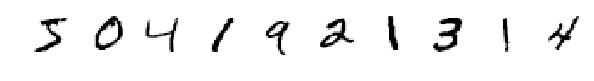

In [3]:
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import sys
import numpy as np

# Load the dataset
(X_train, _), (X_test, _) = mnist.load_data()

# Rescale -1 to 1
X_train = X_train / 127.5 - 1.

X_train = np.reshape(X_train, [-1, 28, 28, 1])
X_test = np.reshape(X_test, [-1, 28, 28, 1])

X_train.shape
callbacks.show(X_train[:10])

# Regular Training

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.

0 [D loss: 0.738701, acc.: 48.83%] [G loss: 0.867334]

1 [D loss: 0.562610, acc.: 69.14%] [G loss: 0.852699]

2 [D loss: 0.843693, acc.: 34.77%] [G loss: 0.693646]

3 [D loss: 0.690617, acc.: 50.39%] [G loss: 0.797524]

4 [D loss: 0.695728, acc.: 51.56%] [G loss: 0.799564]

5 [D loss: 0.550260, acc.: 68.75%] [G loss: 0.906359]

6 [D loss: 0.696336, acc.: 54.30%] [G loss: 0.849765]

7 [D loss: 0.721776, acc.: 48.83%] [G loss: 0.820787]

8 [D loss: 0.738849, acc.: 46.09%] [G loss: 0.786108]

9 [D loss: 0.712282, acc.: 48.83%] [G loss: 0.802364]


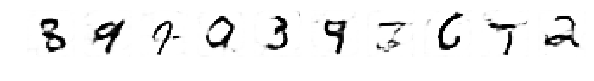

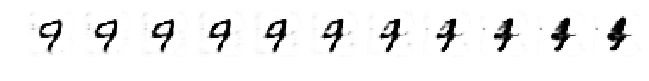

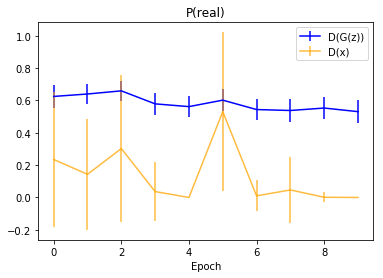

TypeError: ignored

In [4]:
gan = gan.DCGAN(gan.Uniform(100))

        

pmetric = callbacks.PMetrics(gan, X_test[:1000])
train_callbacks = [
    (callbacks.EvolvingImageCallback(gan).plot, 10),
    (callbacks.InterpolationCallback(gan).plot, 10),
    (pmetric.track, 1),
    (pmetric.plot, 10),
    (lambda: gan.save('models_mnist'), 10),
    (callbacks.InverseDistributionCallback(gan, X_train[:100], "X_train").plot, 10),
    (callbacks.InverseDistributionCallback(gan, X_test[:100], "X_test").plot, 10)
]
  
gan.train(X_train, epochs=100, batch_size=128, callbacks=train_callbacks)

# Unconnected Support Prior

In [0]:
gan = DCGAN(Unconnected(100))

        

pmetric = PMetrics(gan, X_test[:1000])
callbacks = [
    (EvolvingImageCallback(gan).plot, 10),
    (InterpolationCallback(gan).plot, 10),
    (pmetric.track, 1),
    (pmetric.plot, 10),
    (lambda: gan.save('models_mnist'), 10),
    (InverseDistributionCallback(gan, X_train[:100], "X_train").plot, 10),
    (InverseDistributionCallback(gan, X_test[:100], "X_test").plot, 10)
]
  
gan.train(X_train, epochs=100, batch_size=128, callbacks=callbacks)